# Step 1: Import Required Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    roc_curve, 
    roc_auc_score,
    precision_recall_curve,
    auc
)


# Step 2: Load and Preprocess Data

In [17]:
# Load the dataset
data = pd.read_csv('Ransomware.csv', sep='|')

# Drop rows with missing values
data = data.dropna()
if 'Name' in data.columns:
    data = data.drop('Name', axis=1)
if 'md5' in data.columns:
    data = data.drop('md5', axis=1)

 #Check for other non-numeric columns
non_numeric_cols = data.select_dtypes(include=['object']).columns
if len(non_numeric_cols) > 0:
    print(f"Dropping non-numeric columns: {list(non_numeric_cols)}")
    data = data.drop(non_numeric_cols, axis=1)


# Separate features (X) and target (y)
X = data.drop('legitimate', axis=1)
y = data['legitimate']

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (important for KNN and SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Train and Evaluate Models

## 1. Random Forest (Baseline Model)

In [19]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

print("Random Forest Metrics:")
print(classification_report(y_test, rf_pred))
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.4f}")

Random Forest Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19250
           1       0.99      0.99      0.99      8360

    accuracy                           1.00     27610
   macro avg       0.99      0.99      0.99     27610
weighted avg       1.00      1.00      1.00     27610

Accuracy: 0.9952


## 2. K-Nearest Neighbors (KNN)

In [20]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
knn_pred = knn_model.predict(X_test_scaled)

print("\nKNN Metrics:")
print(classification_report(y_test, knn_pred))
print(f"Accuracy: {accuracy_score(y_test, knn_pred):.4f}")


KNN Metrics:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19250
           1       0.98      0.99      0.99      8360

    accuracy                           0.99     27610
   macro avg       0.99      0.99      0.99     27610
weighted avg       0.99      0.99      0.99     27610

Accuracy: 0.9909


## 3. Support Vector Machine (SVM)

In [21]:
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)

print("\nSVM Metrics:")
print(classification_report(y_test, svm_pred))
print(f"Accuracy: {accuracy_score(y_test, svm_pred):.4f}")


SVM Metrics:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19250
           1       0.98      0.98      0.98      8360

    accuracy                           0.99     27610
   macro avg       0.99      0.99      0.99     27610
weighted avg       0.99      0.99      0.99     27610

Accuracy: 0.9889


# Step 4: Visualizations for Model Comparison

## 1. Confusion Matrix Heatmaps

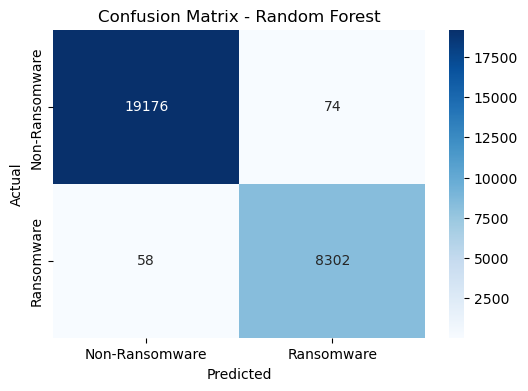

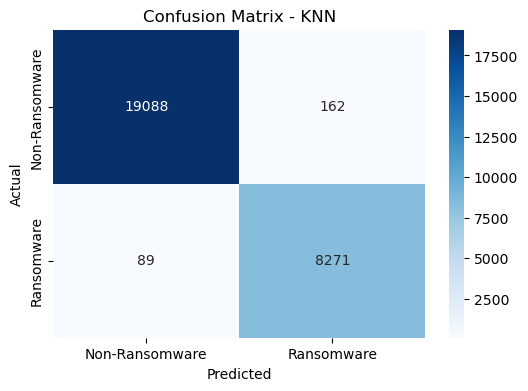

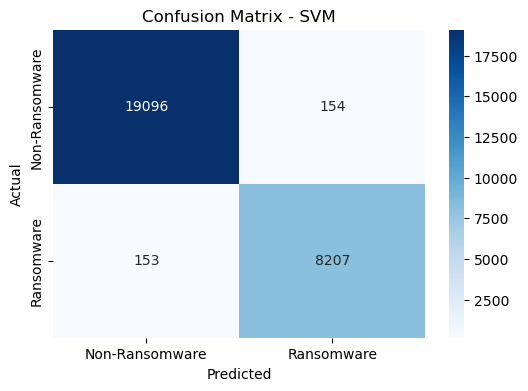

In [22]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Ransomware', 'Ransomware'],
                yticklabels=['Non-Ransomware', 'Ransomware'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(y_test, rf_pred, "Random Forest")
plot_confusion_matrix(y_test, knn_pred, "KNN")
plot_confusion_matrix(y_test, svm_pred, "SVM")

## 2. ROC Curve (Model Performance Comparison)

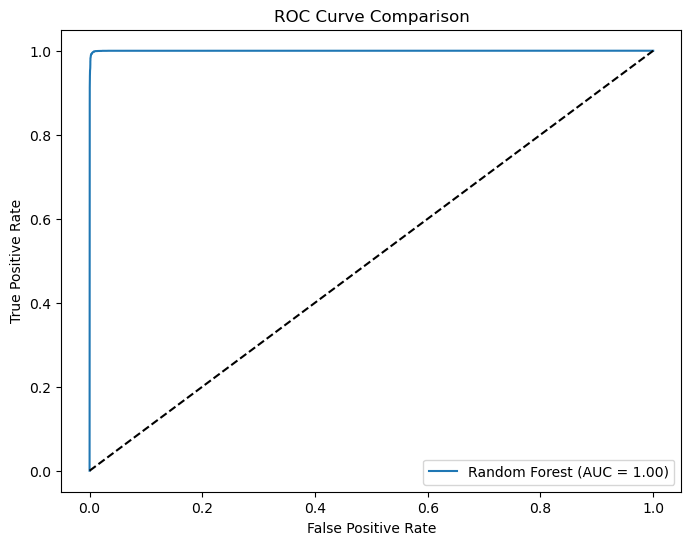

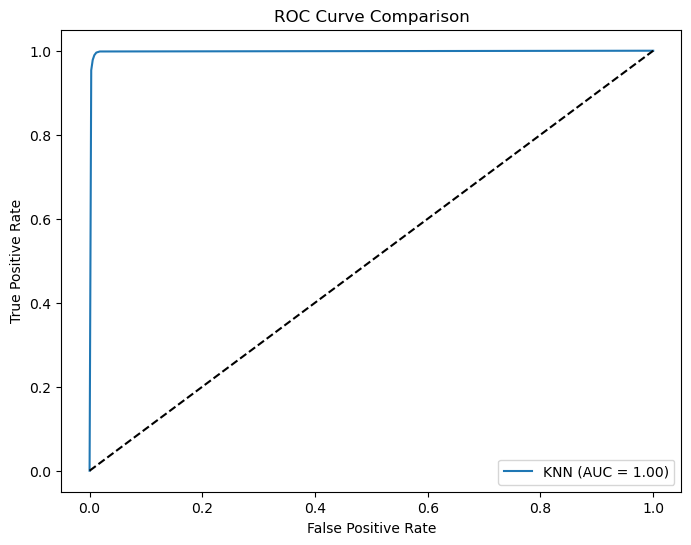

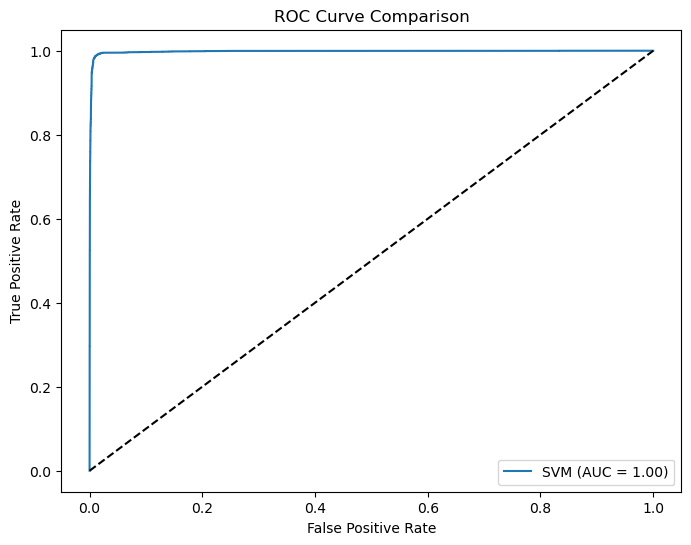

In [24]:
def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.show()

# Get predicted probabilities for ROC
rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
knn_proba = knn_model.predict_proba(X_test_scaled)[:, 1]
svm_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

plot_roc_curve(y_test, rf_proba, "Random Forest")
plot_roc_curve(y_test, knn_proba, "KNN")
plot_roc_curve(y_test, svm_proba, "SVM")

## 3.Precision-Recall Curve

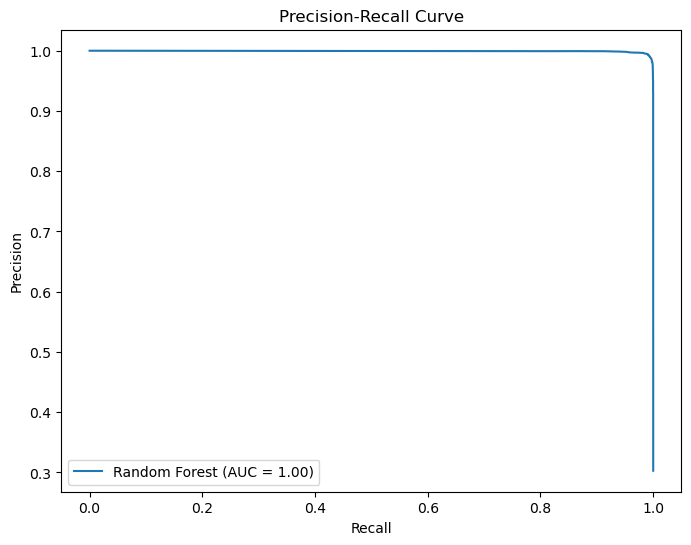

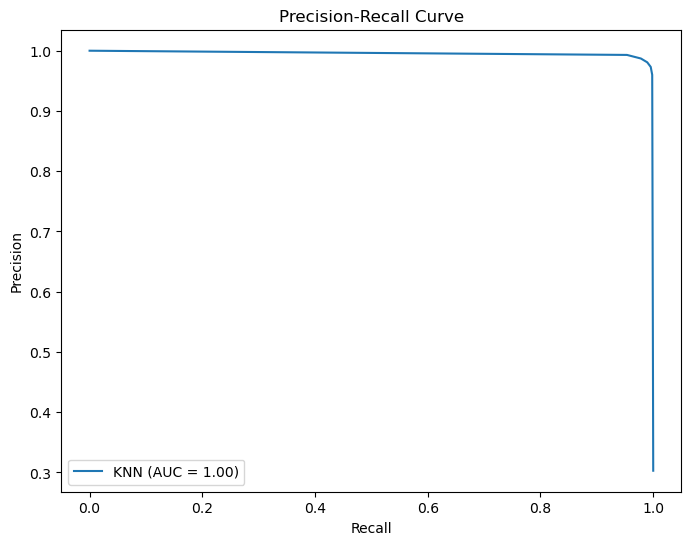

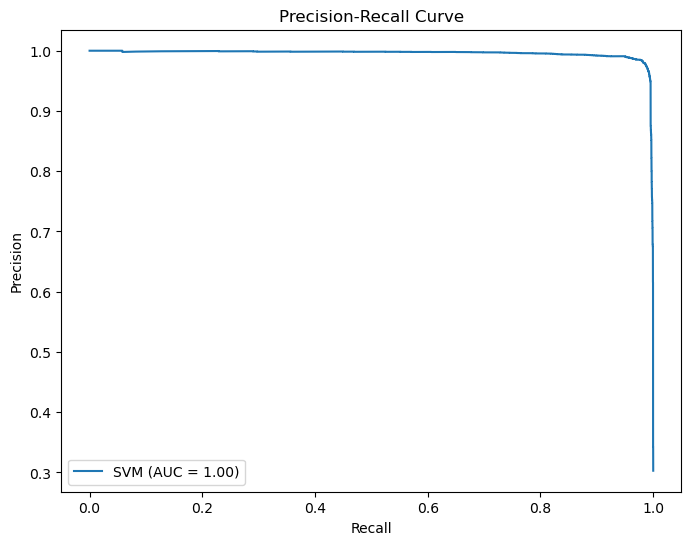

In [25]:
def plot_precision_recall(y_true, y_pred_proba, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

plot_precision_recall(y_test, rf_proba, "Random Forest")
plot_precision_recall(y_test, knn_proba, "KNN")
plot_precision_recall(y_test, svm_proba, "SVM")

## 4. Feature Importance (Random Forest)

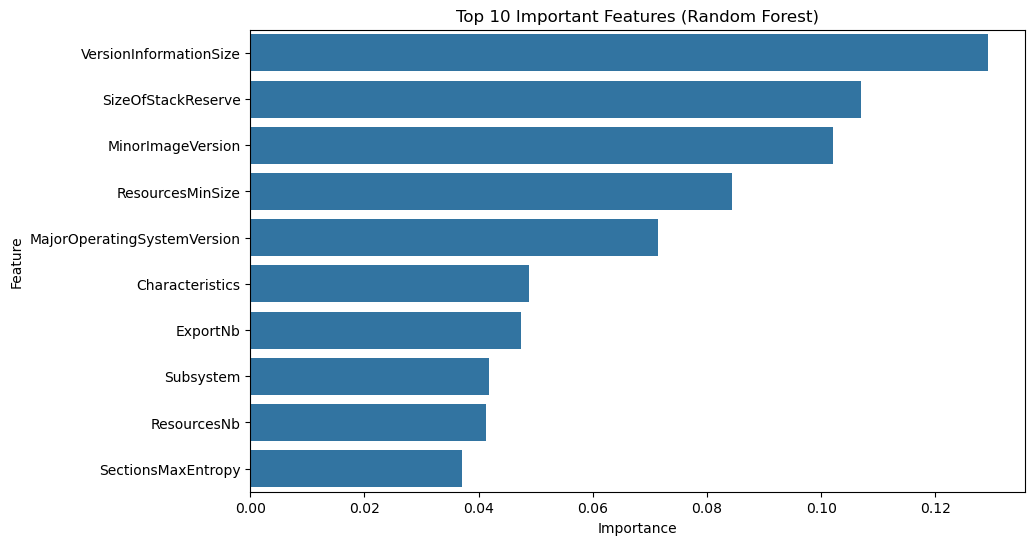

In [26]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Important Features (Random Forest)')
plt.show()

#  5. Compare perfomance of the different models

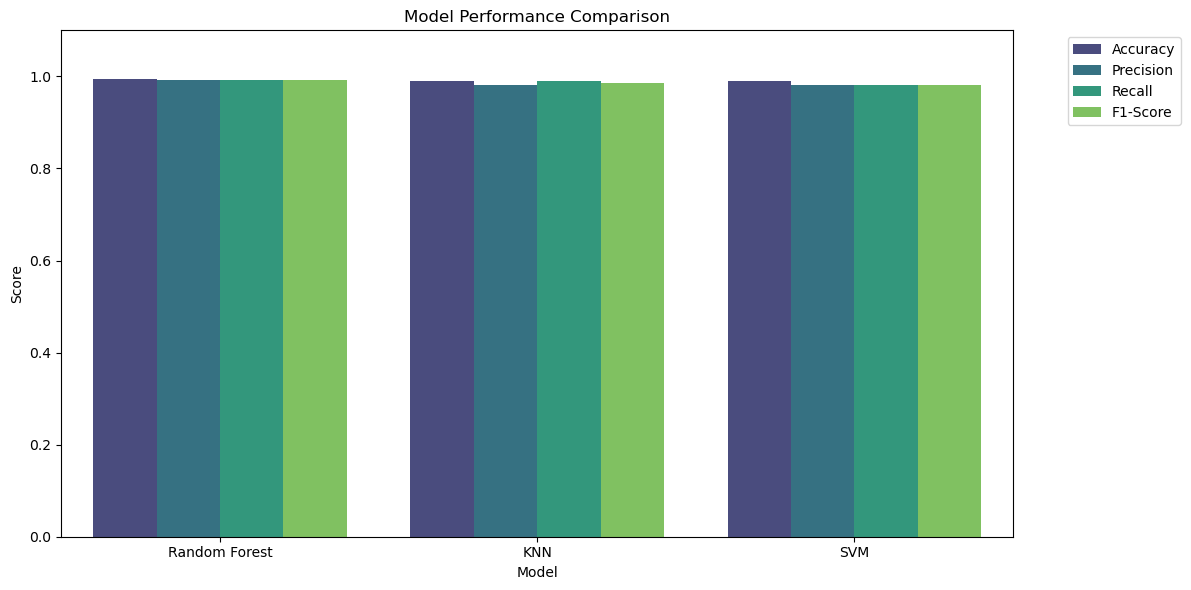

In [28]:
# Create a comparison graph for all models
def plot_metrics_comparison(y_test, rf_pred, knn_pred, svm_pred):
    # Calculate metrics for each model
    models = ['Random Forest', 'KNN', 'SVM']
    predictions = [rf_pred, knn_pred, svm_pred]
    
    accuracy = [accuracy_score(y_test, pred) for pred in predictions]
    precision = [precision_score(y_test, pred) for pred in predictions]
    recall = [recall_score(y_test, pred) for pred in predictions]
    f1 = [f1_score(y_test, pred) for pred in predictions]
    
    # Prepare data for plotting
    metrics_df = pd.DataFrame({
        'Model': models * 4,
        'Metric': ['Accuracy']*3 + ['Precision']*3 + ['Recall']*3 + ['F1-Score']*3,
        'Value': accuracy + precision + recall + f1
    })
    
    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='Value', hue='Metric', data=metrics_df, palette='viridis')
    plt.title('Model Performance Comparison')
    plt.ylim(0, 1.1)
    plt.ylabel('Score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Add these imports at the top if not already present
from sklearn.metrics import precision_score, recall_score, f1_score

# Call the comparison function
plot_metrics_comparison(y_test, rf_pred, knn_pred, svm_pred)

# 6.Combined ROC curve plot for all three models

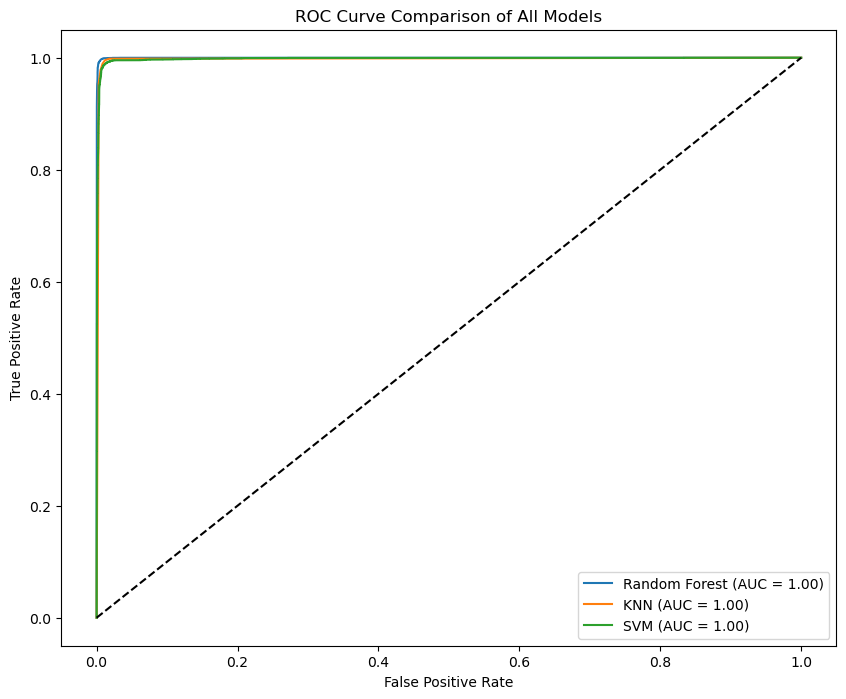

In [29]:
# Combined ROC curve plot
def plot_combined_roc(y_test, rf_proba, knn_proba, svm_proba):
    plt.figure(figsize=(10, 8))
    
    # Calculate and plot for each model
    for name, proba in [('Random Forest', rf_proba), 
                        ('KNN', knn_proba), 
                        ('SVM', svm_proba)]:
        fpr, tpr, _ = roc_curve(y_test, proba)
        roc_auc = roc_auc_score(y_test, proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison of All Models')
    plt.legend(loc='lower right')
    plt.show()

plot_combined_roc(y_test, rf_proba, knn_proba, svm_proba)